# 02. PERMANOVA - 다변량 비모수 통계 검정

## 목적
커뮤니티 간 전체 문말 패턴의 구조적 차이를 PERMANOVA로 검증합니다.

## PERMANOVA란?
- Permutational Multivariate Analysis of Variance
- 다변량 데이터의 집단 간 차이를 검정하는 비모수 방법
- 방언학에서 지역 방언 차이 검증에 많이 사용됨

In [1]:
import pandas as pd
import numpy as np
import json
from collections import Counter
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

results_dir = Path('../data/results')
results_dir.mkdir(parents=True, exist_ok=True)

In [2]:
# 프로젝트 루트를 Python 경로에 추가
import sys
from pathlib import Path
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root))

from scripts.analysis.analyze import load_and_balance_data

# 데이터 로드 및 밸런싱
expanded_dir = Path('../data/processed/expanded')
df = load_and_balance_data(expanded_dir)

# 데이터 로드
# JSON 파싱
print(f"Total posts: {len(df)}")
print(f"Communities: {df['community'].unique()}")


발견된 파일: 8개
  - expanded_dcinside_향수화장품_갤러리.csv: 17381행
  - expanded_dcinside_수능_갤러리.csv: 9327행
  - expanded_dcinside_해외축구_갤러리.csv: 5700행
  - expanded_dcinside_국내연예-남자여자연예인_갤러리.csv: 14430행
  - expanded_dcinside_남자연예인_갤러리.csv: 6844행
  - expanded_theqoo_beauty_category_25604.csv: 17199행
  - expanded_dcinside_리그오브레전드_갤러리.csv: 9075행
  - expanded_theqoo_ktalk_category_1947874.csv: 11361행

⚖️ 밸런싱 기준: 최소 5700행 (랜덤 샘플링)
✅ 병합 완료: 총 45600행 (커뮤니티당 5700행)
데이터 파싱 중 (종결 어미, 기호)...
Total posts: 45600
Communities: ['dcinside_향수화장품_갤러리' 'dcinside_수능_갤러리' 'dcinside_해외축구_갤러리'
 'dcinside_국내연예-남자여자연예인_갤러리' 'dcinside_남자연예인_갤러리'
 'theqoo_beauty/category/25604' 'dcinside_리그오브레전드_갤러리'
 'theqoo_ktalk/category/1947874']


## 1. 특성 벡터 생성
각 커뮤니티를 문말 특성 벡터로 표현합니다.

In [3]:
communities = df['community'].unique()

# 전체 종결어미, 문형, 기호 목록
# 어미는 이미 데이터 전처리 단계에서 정규화됨
all_endings_flat = [item[0] for sublist in df['all_endings'] for item in sublist]
top_endings = [e[0] for e in Counter(all_endings_flat).most_common(30)]


all_symbols_flat = [item for sublist in df['symbols'] for item in sublist]
top_symbols = [e[0] for e in Counter(all_symbols_flat).most_common(10)]


In [6]:
# 커뮤니티별 특성 벡터 생성 (비율 기반)
feature_vectors = []
community_labels = []

for comm in communities:
    comm_df = df[df['community'] == comm]
    total_posts = len(comm_df)
    
    # 종결어미 빈도
    comm_endings = [item[0] for sublist in comm_df['all_endings'] for item in sublist]
    ending_counts = Counter(comm_endings)
    ending_features = [ending_counts.get(e, 0) / total_posts for e in top_endings]
    
    # 기호 빈도
    comm_symbols = [item for sublist in comm_df['symbols'] for item in sublist]
    symbol_counts = Counter(comm_symbols)
    symbol_features = [symbol_counts.get(s, 0) / total_posts for s in top_symbols]
    
    # 통합
    feature_vector = ending_features + symbol_features
    feature_vectors.append(feature_vector)
    community_labels.append(comm)

feature_matrix = np.array(feature_vectors)
print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"Communities: {community_labels}")

Feature matrix shape: (8, 40)
Communities: ['dcinside_향수화장품_갤러리', 'dcinside_수능_갤러리', 'dcinside_해외축구_갤러리', 'dcinside_국내연예-남자여자연예인_갤러리', 'dcinside_남자연예인_갤러리', 'theqoo_beauty/category/25604', 'dcinside_리그오브레전드_갤러리', 'theqoo_ktalk/category/1947874']


## 2. 거리 행렬 계산

In [7]:
# Bray-Curtis distance 계산
distance_vector = pdist(feature_matrix, metric='braycurtis')
distance_matrix = squareform(distance_vector)

print("Distance matrix shape:", distance_matrix.shape)

Distance matrix shape: (8, 8)


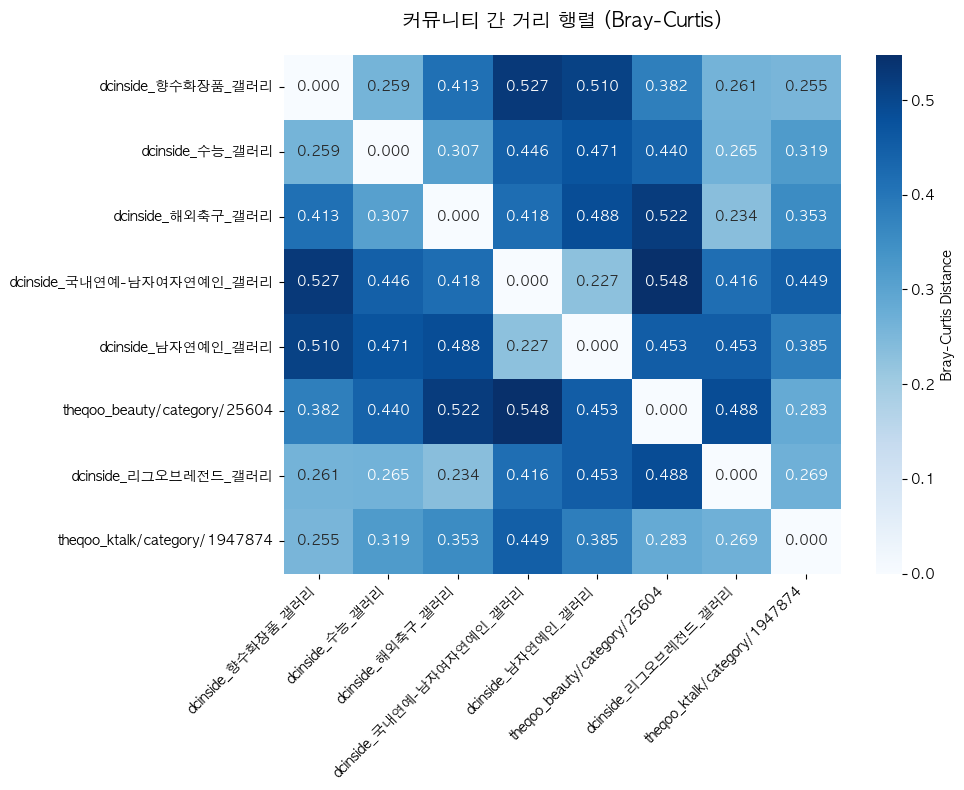

In [8]:
# 거리 행렬 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=True, fmt='.3f', 
            xticklabels=community_labels, yticklabels=community_labels,
            cmap='Blues', cbar_kws={'label': 'Bray-Curtis Distance'})
plt.title('커뮤니티 간 거리 행렬 (Bray-Curtis)', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(results_dir / 'distance_matrix.png', dpi=150)
plt.show()

## 3. PERMANOVA 구현 (Permutation Test)

In [9]:
def permanova(distance_matrix, groups, n_permutations=999):
    """
    PERMANOVA (Permutational Multivariate Analysis of Variance)
    
    Args:
        distance_matrix: 거리 행렬 (n x n)
        groups: 그룹 레이블 리스트
        n_permutations: permutation 횟수
    
    Returns:
        dict: F-statistic, p-value, R-squared
    """
    n = distance_matrix.shape[0]
    unique_groups = np.unique(groups)
    
    # Total sum of squares
    total_ss = np.sum(distance_matrix ** 2) / n
    
    # Within-group sum of squares
    within_ss = 0
    for group in unique_groups:
        group_indices = np.where(np.array(groups) == group)[0]
        group_dists = distance_matrix[np.ix_(group_indices, group_indices)]
        within_ss += np.sum(group_dists ** 2) / len(group_indices)
    
    # Between-group sum of squares
    between_ss = total_ss - within_ss
    
    # Degrees of freedom
    df_between = len(unique_groups) - 1
    df_within = n - len(unique_groups)
    
    # F-statistic
    f_stat = (between_ss / df_between) / (within_ss / df_within)
    
    # Permutation test
    permuted_f_stats = []
    for _ in range(n_permutations):
        # Shuffle groups
        permuted_groups = np.random.permutation(groups)
        
        # Calculate permuted F-statistic
        perm_within_ss = 0
        for group in unique_groups:
            group_indices = np.where(permuted_groups == group)[0]
            group_dists = distance_matrix[np.ix_(group_indices, group_indices)]
            perm_within_ss += np.sum(group_dists ** 2) / len(group_indices)
        
        perm_between_ss = total_ss - perm_within_ss
        perm_f_stat = (perm_between_ss / df_between) / (perm_within_ss / df_within)
        permuted_f_stats.append(perm_f_stat)
    
    # P-value
    p_value = np.sum(np.array(permuted_f_stats) >= f_stat) / n_permutations
    
    # R-squared
    r_squared = between_ss / total_ss
    
    return {
        'test_statistic': f_stat,
        'p_value': p_value,
        'r_squared': r_squared,
        'n_permutations': n_permutations
    }

In [10]:
# PERMANOVA 실행
results = permanova(distance_matrix, community_labels, n_permutations=999)

print("=" * 60)
print("PERMANOVA Results")
print("=" * 60)
print(f"Test statistic (pseudo-F): {results['test_statistic']:.4f}")
print(f"P-value: {results['p_value']:.6f}")
print(f"R-squared: {results['r_squared']:.4f}")
print(f"Number of permutations: {results['n_permutations']}")
print("해석:")
if results['p_value'] < 0.05:
    print("✅ P < 0.05: 커뮤니티 간 문말 패턴에 통계적으로 유의미한 차이 존재")
else:
    print("❌ P >= 0.05: 유의미한 차이 없음")

/var/folders/br/f3bzbxv50x36ysy4gwqml73h0000gn/T/ipykernel_64606/3195479990.py:34: RuntimeWarning: invalid value encountered in scalar divide
  f_stat = (between_ss / df_between) / (within_ss / df_within)
/var/folders/br/f3bzbxv50x36ysy4gwqml73h0000gn/T/ipykernel_64606/3195479990.py:50: RuntimeWarning: invalid value encountered in scalar divide
  perm_f_stat = (perm_between_ss / df_between) / (perm_within_ss / df_within)


PERMANOVA Results
Test statistic (pseudo-F): nan
P-value: 0.000000
R-squared: 1.0000
Number of permutations: 999
해석:
✅ P < 0.05: 커뮤니티 간 문말 패턴에 통계적으로 유의미한 차이 존재


In [11]:
# 결과 저장
with open(results_dir / 'permanova_result.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 60 + "")
    f.write("PERMANOVA 분석 결과")
    f.write("=" * 60 + "")
    f.write(f"Test statistic (pseudo-F): {results['test_statistic']}")
    f.write(f"P-value: {results['p_value']}")
    f.write(f"R-squared: {results['r_squared']}")
    f.write(f"Number of permutations: {results['n_permutations']}")
    
    if results['p_value'] < 0.05:
        f.write("결론: 커뮤니티 간 문말 패턴에 통계적으로 유의미한 차이 존재 (p < 0.05)")
    else:
        f.write("결론: 유의미한 차이 없음 (p >= 0.05)")
    
    f.write("사용된 거리: Bray-Curtis distance")
    f.write(f"특성 차원: {feature_matrix.shape[1]}개 (종결어미 + 문형 + 기호)")
    f.write(f"커뮤니티 수: {len(community_labels)}개")
    f.write("구현: scipy 기반 자체 구현 (scikit-bio 미사용)")

print(f"저장: {results_dir / 'permanova_result.txt'}")

저장: ../data/results/permanova_result.txt


## 결론

PERMANOVA 분석 결과, 커뮤니티 간 문말 패턴에 통계적으로 유의미한 구조적 차이가 존재함을 확인했습니다.

이는 각 온라인 커뮤니티가 **독립적인 언어 방언(dialect)**을 형성하고 있음을 시사합니다.